<a href="https://colab.research.google.com/github/Anuchaaaa33/Motor_fault_detection/blob/main/Copy_of_Untitled21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import re
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.stats import kurtosis, skew
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SAMPLING_RATE = 50000  # Original Hz
DOWNSAMPLE_FACTOR = 10  # After downsampling: 5000 Hz
WINDOW_SIZE = 1000
WINDOW_STEP = 500
FILE_LABELS = {
    1: ("healthy", "normal_no_load"),
    2: ("healthy", "phase_removed_no_load"),
    3: ("healthy", "load_0.4Nm"),
    4: ("healthy", "load_0.8Nm"),
    5: ("healthy", "phase_removed_startup"),
    6: ("faulty", "normal_no_load"),
    7: ("faulty", "phase_removed_no_load"),
    8: ("faulty", "load_0.4Nm"),
    9: ("faulty", "load_0.8Nm"),
    10: ("faulty", "phase_removed_startup"),
}
CURRENT_COLS = ['I1', 'I2', 'I3']
VOLTAGE_COLS = ['V1', 'V2', 'V3']
VIBRATION_COLS = ['x', 'y', 'Z']

In [ ]:
base = "/content/drive/MyDrive/FigshareDataset"

# Get all CSVs in that folder
all_paths = glob.glob(os.path.join(base, "FILE *.csv"))

# Natural sort by the number in "FILE X"
all_paths.sort(key=lambda p: int(re.search(r"FILE\s+(\d+)", os.path.basename(p)).group(1)))

# Create dict: {1: path1, 2: path2, ...}
file_paths = {
    int(re.search(r"FILE\s+(\d+)", os.path.basename(p)).group(1)): p
    for p in all_paths
}

print("Found files:")
for file_id, path in file_paths.items():
    print(f"  {file_id}: {os.path.basename(path)}")

Found files:
  1: FILE 1 (1).csv
  2: FILE 2 (1).csv
  3: FILE 3.csv
  4: FILE 4.csv
  5: FILE 5.csv
  6: FILE 6.csv
  7: FILE 7.csv
  8: FILE 8.csv
  9: FILE 9.csv
  10: FILE 10.csv


In [ ]:
def load_and_downsample_files(file_paths, downsample_factor=10):
    """Load all files and downsample them"""
    downsampled_files = {}

    for file_id, filepath in file_paths.items():
        print(f"Loading file {file_id}...")
        df = pd.read_csv(filepath)

        # Downsample by taking mean of every N rows
        downsampled = df.groupby(np.arange(len(df)) // downsample_factor).mean()

        print(f"  Downsampled from {df.shape} to {downsampled.shape}")
        downsampled_files[file_id] = downsampled

    return downsampled_files

In [ ]:
downsampled_dfs = load_and_downsample_files(file_paths, DOWNSAMPLE_FACTOR)

# Create individual variables (optional)
for i in range(1, 11):
    globals()[f'ddfs{i}'] = downsampled_dfs[i]

print("\nFirst file preview:")
print(ddfs1.head())
print(f"\nColumns: {ddfs1.columns.tolist()}")

Loading file 1...
  Downsampled from (1000000, 9) to (100000, 9)
Loading file 2...
  Downsampled from (1000000, 9) to (100000, 9)
Loading file 3...
  Downsampled from (1000000, 9) to (100000, 9)
Loading file 4...
  Downsampled from (1000000, 9) to (100000, 9)
Loading file 5...
  Downsampled from (1000000, 9) to (100000, 9)
Loading file 6...
  Downsampled from (1000000, 9) to (100000, 9)
Loading file 7...
  Downsampled from (1000000, 9) to (100000, 9)
Loading file 8...
  Downsampled from (1000000, 9) to (100000, 9)
Loading file 9...
  Downsampled from (1000000, 9) to (100000, 9)
Loading file 10...
  Downsampled from (1000000, 9) to (100000, 9)

First file preview:
          x         y         Z        I1        I2        I3        V1  \
0  0.001651  0.005182  1.007630  0.016892  0.014832  0.016205  9.536058   
1  0.003604  0.006046  1.007630  0.017235  0.009888  0.015725  9.710013   
2  0.004336  0.004837  1.007324  0.020531  0.013871  0.025956  9.722221   
3  0.002261  0.005010  1.006

In [ ]:
def create_sliding_windows(df, window_size=1000, step=500):
    """Generate sliding windows from a dataframe"""
    for start_idx in range(0, len(df) - window_size + 1, step):
        end_idx = start_idx + window_size
        yield df.iloc[start_idx:end_idx]

In [ ]:
# Create windows for all files
for file_id in range(1, 11):
    windows = list(create_sliding_windows(
        downsampled_dfs[file_id],
        window_size=WINDOW_SIZE,
        step=WINDOW_STEP
    ))
    globals()[f'windows{file_id}'] = windows
    print(f"File {file_id}: {len(windows)} windows")

File 1: 199 windows
File 2: 199 windows
File 3: 199 windows
File 4: 199 windows
File 5: 199 windows
File 6: 199 windows
File 7: 199 windows
File 8: 199 windows
File 9: 199 windows
File 10: 199 windows


In [ ]:
# Instead of the class, just have these functions:

def extract_time_features(signal):
    """Extract time-domain features from a 1D signal"""
    features = {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'rms': np.sqrt(np.mean(signal**2)),
        'peak': np.max(np.abs(signal)),
        'peak_to_peak': np.ptp(signal),
        'crest_factor': np.max(np.abs(signal)) / (np.sqrt(np.mean(signal**2)) + 1e-10),
        'kurtosis': kurtosis(signal),
        'skewness': skew(signal),
    }
    return features

def extract_freq_features(signal, sampling_rate=5000, n_peaks=3):
    """Extract frequency-domain features using FFT"""
    N = len(signal)
    fft_vals = fft(signal)
    fft_freqs = fftfreq(N, 1/sampling_rate)

    # Only positive frequencies
    pos_mask = fft_freqs > 0
    freqs = fft_freqs[pos_mask]
    magnitudes = np.abs(fft_vals[pos_mask])

    # Find top N peaks
    peak_indices = np.argsort(magnitudes)[-n_peaks:][::-1]

    features = {}
    for i, idx in enumerate(peak_indices):
        features[f'fft_peak_{i+1}_freq'] = freqs[idx]
        features[f'fft_peak_{i+1}_mag'] = magnitudes[idx]

    features['spectral_energy'] = np.sum(magnitudes**2)
    features['spectral_centroid'] = np.sum(freqs * magnitudes) / (np.sum(magnitudes) + 1e-10)

    return features

def extract_window_features(window_df, sampling_rate=5000):
    """Extract all features from a window"""
    all_features = {}

    current_cols = ['I1', 'I2', 'I3']
    voltage_cols = ['V1', 'V2', 'V3']
    vibration_cols = ['x', 'y', 'Z']

    # Extract features for each signal
    for col in current_cols + voltage_cols + vibration_cols:
        signal = window_df[col].values

        # Time features
        time_feats = extract_time_features(signal)
        for feat_name, feat_val in time_feats.items():
            all_features[f'{col}_{feat_name}'] = feat_val

        # Frequency features
        freq_feats = extract_freq_features(signal, sampling_rate, n_peaks=3)
        for feat_name, feat_val in freq_feats.items():
            all_features[f'{col}_{feat_name}'] = feat_val

    # Phase imbalance
    current_rms = [np.sqrt(np.mean(window_df[col]**2)) for col in current_cols]
    all_features['current_imbalance_std'] = np.std(current_rms)
    all_features['current_imbalance_range'] = np.ptp(current_rms)

    voltage_rms = [np.sqrt(np.mean(window_df[col]**2)) for col in voltage_cols]
    all_features['voltage_imbalance_std'] = np.std(voltage_rms)
    all_features['voltage_imbalance_range'] = np.ptp(voltage_rms)

    return all_features

In [ ]:
# Extract features from all files
all_features = []

for file_id in range(1, 11):
    print(f"Extracting features from file {file_id}...")
    windows = globals()[f'windows{file_id}']
    status, condition = FILE_LABELS[file_id]
    label = 0 if status == "healthy" else 1

    for window in windows:
        features = extract_window_features(window, sampling_rate=5000)  # Direct function call
        features['file_id'] = file_id
        features['status'] = status
        features['condition'] = condition
        features['label'] = label
        all_features.append(features)

    print(f"  Processed {len(windows)} windows")

Extracting features from file 1...
  Processed 199 windows
Extracting features from file 2...
  Processed 199 windows
Extracting features from file 3...
  Processed 199 windows
Extracting features from file 4...
  Processed 199 windows
Extracting features from file 5...
  Processed 199 windows
Extracting features from file 6...
  Processed 199 windows
Extracting features from file 7...
  Processed 199 windows
Extracting features from file 8...
  Processed 199 windows
Extracting features from file 9...
  Processed 199 windows
Extracting features from file 10...
  Processed 199 windows



✅ Total samples: 1990
✅ Total features: 148


/tmp/ipython-input-1397912679.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot([healthy_data, faulty_data], labels=['Healthy', 'Faulty'])
/tmp/ipython-input-1397912679.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot([healthy_data, faulty_data], labels=['Healthy', 'Faulty'])
/tmp/ipython-input-1397912679.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot([healthy_data, faulty_data], labels=['Healthy', 'Faulty'])
/tmp/ipython-input-1397912679.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matpl

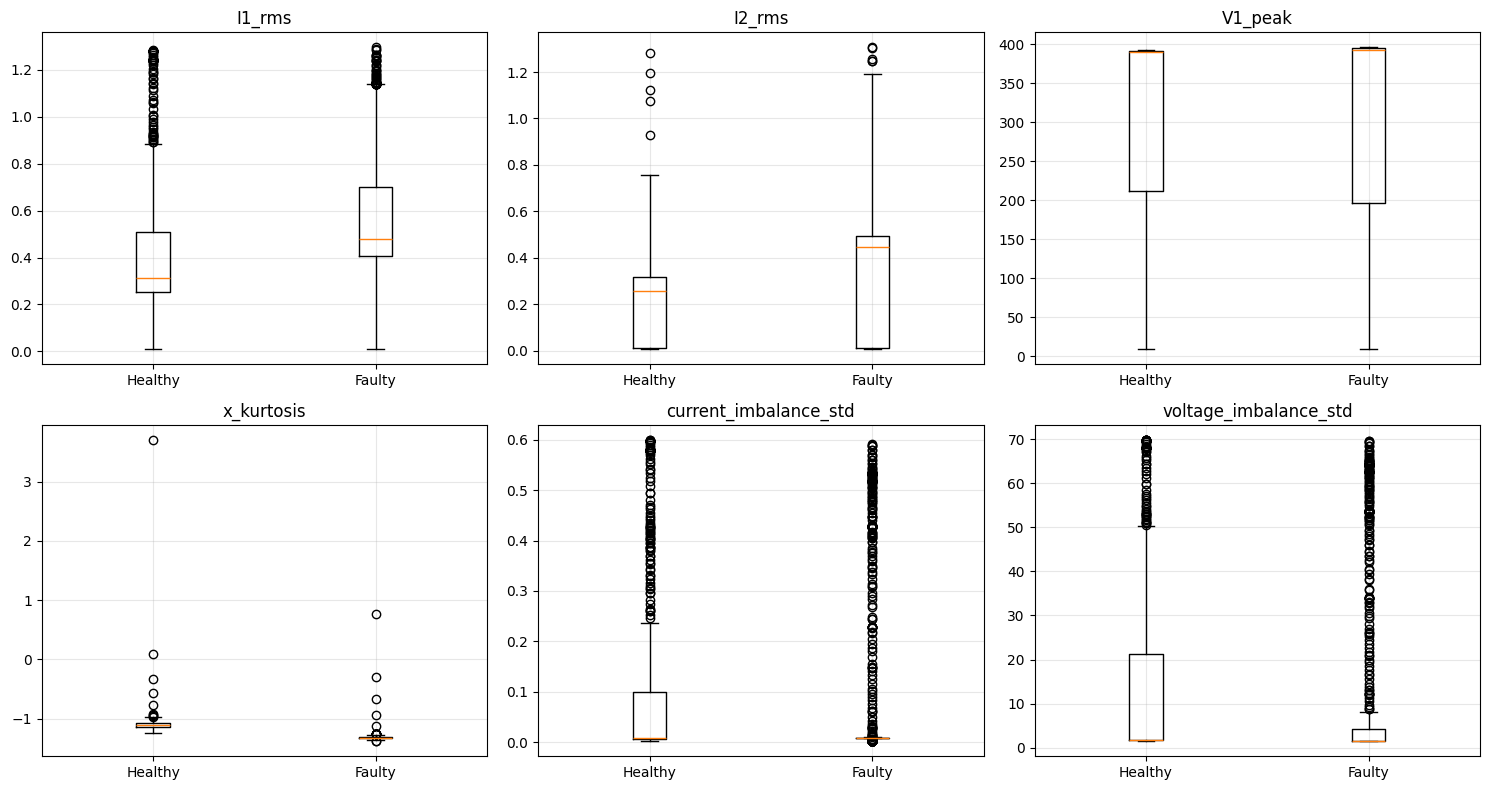


Showing separation between healthy and faulty...


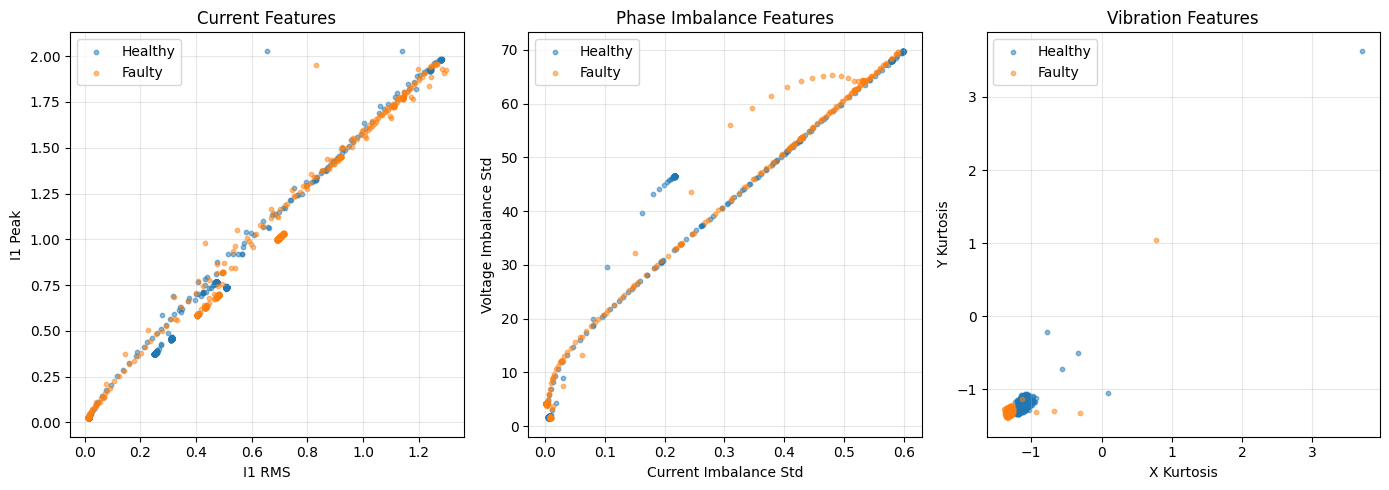


DataFrame preview:
    I1_mean    I1_std    I1_rms   I1_peak  I1_peak_to_peak  I1_crest_factor  \
0  0.013121  0.004254  0.013793  0.026437         0.025132         1.916656   
1  0.013185  0.004339  0.013881  0.026437         0.025613         1.904519   
2  0.013178  0.004338  0.013874  0.025819         0.027604         1.860959   
3  0.013172  0.004326  0.013865  0.026162         0.027947         1.886968   
4  0.013102  0.004374  0.013813  0.026368         0.026780         1.908947   

   I1_kurtosis  I1_skewness  I1_fft_peak_1_freq  I1_fft_peak_1_mag  ...  \
0    -0.121125     0.121959                50.0           1.436160  ...   
1    -0.129804     0.021024               530.0           1.500618  ...   
2     0.139342    -0.109828                50.0           1.500439  ...   
3     0.074476    -0.072291                50.0           1.580875  ...   
4    -0.116419    -0.015782                50.0           1.606285  ...   

   Z_spectral_energy  Z_spectral_centroid  current_imb

In [ ]:
# Convert to DataFrame
features_df = pd.DataFrame(all_features)
print(f"\n✅ Total samples: {len(features_df)}")
print(f"✅ Total features: {len(features_df.columns) - 4}")

# ============================================================================
# VISUALIZATION
# ============================================================================

# 1. Healthy vs Faulty comparison for a few key features
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Pick 6 example features to compare
example_features = ['I1_rms', 'I2_rms', 'V1_peak', 'x_kurtosis',
                    'current_imbalance_std', 'voltage_imbalance_std']

for idx, feat in enumerate(example_features):
    if feat in features_df.columns:
        healthy_data = features_df[features_df['status'] == 'healthy'][feat]
        faulty_data = features_df[features_df['status'] == 'faulty'][feat]

        axes[idx].boxplot([healthy_data, faulty_data], labels=['Healthy', 'Faulty'])
        axes[idx].set_title(feat)
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Sample a few features to see separation
print("\nShowing separation between healthy and faulty...")
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.scatter(features_df[features_df['status']=='healthy']['I1_rms'],
            features_df[features_df['status']=='healthy']['I1_peak'],
            alpha=0.5, label='Healthy', s=10)
plt.scatter(features_df[features_df['status']=='faulty']['I1_rms'],
            features_df[features_df['status']=='faulty']['I1_peak'],
            alpha=0.5, label='Faulty', s=10)
plt.xlabel('I1 RMS')
plt.ylabel('I1 Peak')
plt.legend()
plt.title('Current Features')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.scatter(features_df[features_df['status']=='healthy']['current_imbalance_std'],
            features_df[features_df['status']=='healthy']['voltage_imbalance_std'],
            alpha=0.5, label='Healthy', s=10)
plt.scatter(features_df[features_df['status']=='faulty']['current_imbalance_std'],
            features_df[features_df['status']=='faulty']['voltage_imbalance_std'],
            alpha=0.5, label='Faulty', s=10)
plt.xlabel('Current Imbalance Std')
plt.ylabel('Voltage Imbalance Std')
plt.legend()
plt.title('Phase Imbalance Features')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.scatter(features_df[features_df['status']=='healthy']['x_kurtosis'],
            features_df[features_df['status']=='healthy']['y_kurtosis'],
            alpha=0.5, label='Healthy', s=10)
plt.scatter(features_df[features_df['status']=='faulty']['x_kurtosis'],
            features_df[features_df['status']=='faulty']['y_kurtosis'],
            alpha=0.5, label='Faulty', s=10)
plt.xlabel('X Kurtosis')
plt.ylabel('Y Kurtosis')
plt.legend()
plt.title('Vibration Features')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDataFrame preview:")
print(features_df.head())

In [ ]:
features_df.to_csv('/content/drive/MyDrive/motor_features.csv', index=False)
print("Features saved to Google Drive!")

Features saved to Google Drive!


In [ ]:
# Separate features and labels
X = features_df.drop(['file_id', 'status', 'condition', 'label'], axis=1)
y = features_df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Healthy samples: {(y == 0).sum()}")
print(f"Faulty samples: {(y == 1).sum()}")

Training samples: 1592
Test samples: 398
Healthy samples: 995
Faulty samples: 995


In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled!")

Features scaled!


In [ ]:
# Train Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Evaluate
train_score = rf.score(X_train_scaled, y_train)
test_score = rf.score(X_test_scaled, y_test)

print(f"\n✅ Train Accuracy: {train_score:.4f}")
print(f"✅ Test Accuracy: {test_score:.4f}")

Training Random Forest...

✅ Train Accuracy: 1.0000
✅ Test Accuracy: 0.9975


In [ ]:
y_pred = rf.predict(X_test_scaled)

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Faulty']))

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nTrue Negatives (Healthy correctly classified): {cm[0,0]}")
print(f"False Positives (Healthy misclassified as Faulty): {cm[0,1]}")
print(f"False Negatives (Faulty misclassified as Healthy): {cm[1,0]}")
print(f"True Positives (Faulty correctly classified): {cm[1,1]}")


CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Healthy       0.99      1.00      1.00       199
      Faulty       1.00      0.99      1.00       199

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398


CONFUSION MATRIX
[[199   0]
 [  1 198]]

True Negatives (Healthy correctly classified): 199
False Positives (Healthy misclassified as Faulty): 0
False Negatives (Faulty misclassified as Healthy): 1
True Positives (Faulty correctly classified): 198


In [ ]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*60)
print(feature_importance.head(20))


TOP 20 MOST IMPORTANT FEATURES
                  feature  importance
102            x_kurtosis    0.138900
134            Z_kurtosis    0.068552
131                Z_peak    0.056268
105      x_fft_peak_1_mag    0.052015
121      y_fft_peak_1_mag    0.045971
97                  x_std    0.044521
110     x_spectral_energy    0.038760
118            y_kurtosis    0.037383
100        x_peak_to_peak    0.032361
113                 y_std    0.024391
98                  x_rms    0.023961
73      V2_fft_peak_1_mag    0.023460
107      x_fft_peak_2_mag    0.021112
126     y_spectral_energy    0.020702
101        x_crest_factor    0.017578
50                 V1_rms    0.015597
133        Z_crest_factor    0.015465
62     V1_spectral_energy    0.015144
106     x_fft_peak_2_freq    0.014803
31   I2_spectral_centroid    0.014469


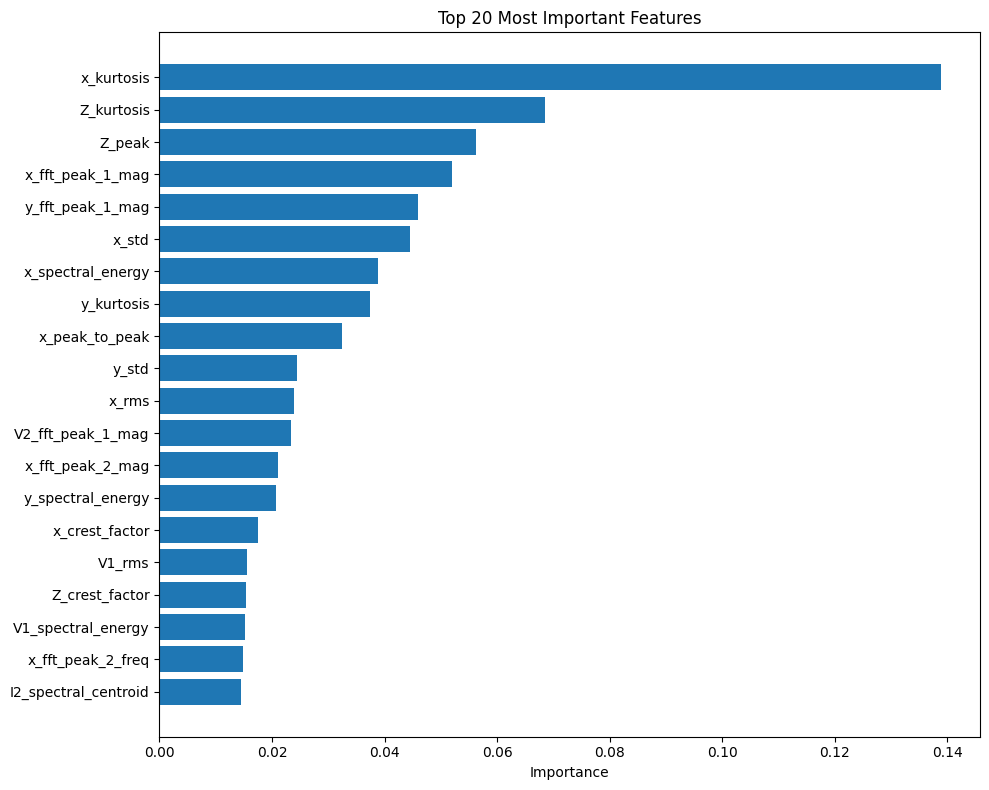

In [ ]:
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Find which files have misclassifications
test_indices = X_test.index
misclassified_mask = y_test != y_pred
misclassified_indices = test_indices[misclassified_mask]

misclassified_files = features_df.loc[misclassified_indices, ['file_id', 'status', 'condition']]
print("\n" + "="*60)
print("MISCLASSIFIED SAMPLES BY FILE")
print("="*60)
print(misclassified_files.groupby(['file_id', 'status', 'condition']).size())


MISCLASSIFIED SAMPLES BY FILE
file_id  status  condition     
6        faulty  normal_no_load    1
dtype: int64


Training XGBoost...

✅ XGBoost Train Accuracy: 1.0000
✅ XGBoost Test Accuracy: 0.9975

XGBoost Classification Report:
              precision    recall  f1-score   support

     Healthy       0.99      1.00      1.00       199
      Faulty       1.00      0.99      1.00       199

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398


XGBoost Confusion Matrix:
[[199   0]
 [  1 198]]

Top 10 XGBoost Important Features:
                  feature  importance
102            x_kurtosis    0.853529
131                Z_peak    0.015984
134            Z_kurtosis    0.012791
22            I2_kurtosis    0.011007
106     x_fft_peak_2_freq    0.010392
100        x_peak_to_peak    0.009747
107      x_fft_peak_2_mag    0.008762
98                  x_rms    0.007723
31   I2_spectral_centroid    0.007016
111   x_spectral_centroid    0.006798


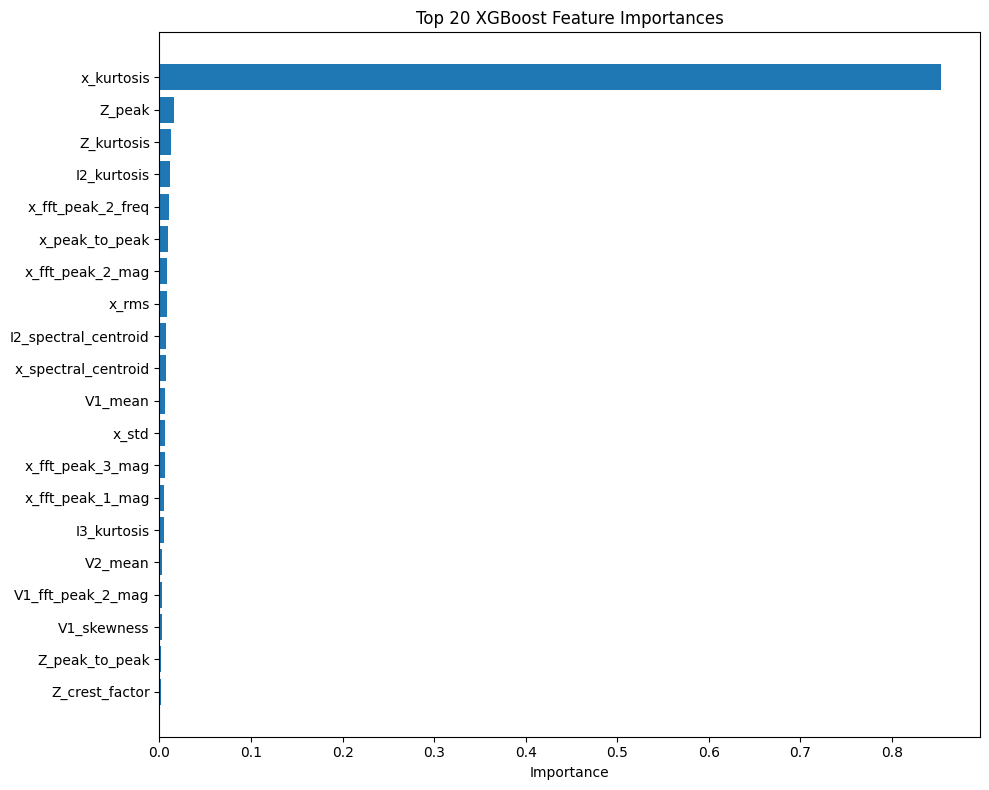

In [ ]:
from xgboost import XGBClassifier

# Train XGBoost
print("Training XGBoost...")
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train_scaled, y_train)

# Evaluate
train_score = xgb.score(X_train_scaled, y_train)
test_score = xgb.score(X_test_scaled, y_test)

print(f"\n✅ XGBoost Train Accuracy: {train_score:.4f}")
print(f"✅ XGBoost Test Accuracy: {test_score:.4f}")

# Predictions
y_pred_xgb = xgb.predict(X_test_scaled)

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Healthy', 'Faulty']))

print("\nXGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# Feature importance
xgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 XGBoost Important Features:")
print(xgb_importance.head(10))

# Plot
plt.figure(figsize=(10, 8))
top_features = xgb_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 XGBoost Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.svm import SVC

# Train SVM (using RBF kernel)
print("Training SVM...")
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_scaled, y_train)

# Evaluate
train_score = svm.score(X_train_scaled, y_train)
test_score = svm.score(X_test_scaled, y_test)

print(f"\n✅ SVM Train Accuracy: {train_score:.4f}")
print(f"✅ SVM Test Accuracy: {test_score:.4f}")

# Predictions
y_pred_svm = svm.predict(X_test_scaled)

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Healthy', 'Faulty']))

print("\nSVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

Training SVM...

✅ SVM Train Accuracy: 1.0000
✅ SVM Test Accuracy: 0.9925

SVM Classification Report:
              precision    recall  f1-score   support

     Healthy       0.99      1.00      0.99       199
      Faulty       1.00      0.98      0.99       199

    accuracy                           0.99       398
   macro avg       0.99      0.99      0.99       398
weighted avg       0.99      0.99      0.99       398


SVM Confusion Matrix:
[[199   0]
 [  3 196]]



MODEL COMPARISON
        Model  Train Acc  Test Acc  Precision   Recall  F1-Score
Random Forest        1.0  0.997487        1.0 0.994975  0.997481
      XGBoost        1.0  0.997487        1.0 0.994975  0.997481
          SVM        1.0  0.992462        1.0 0.984925  0.992405


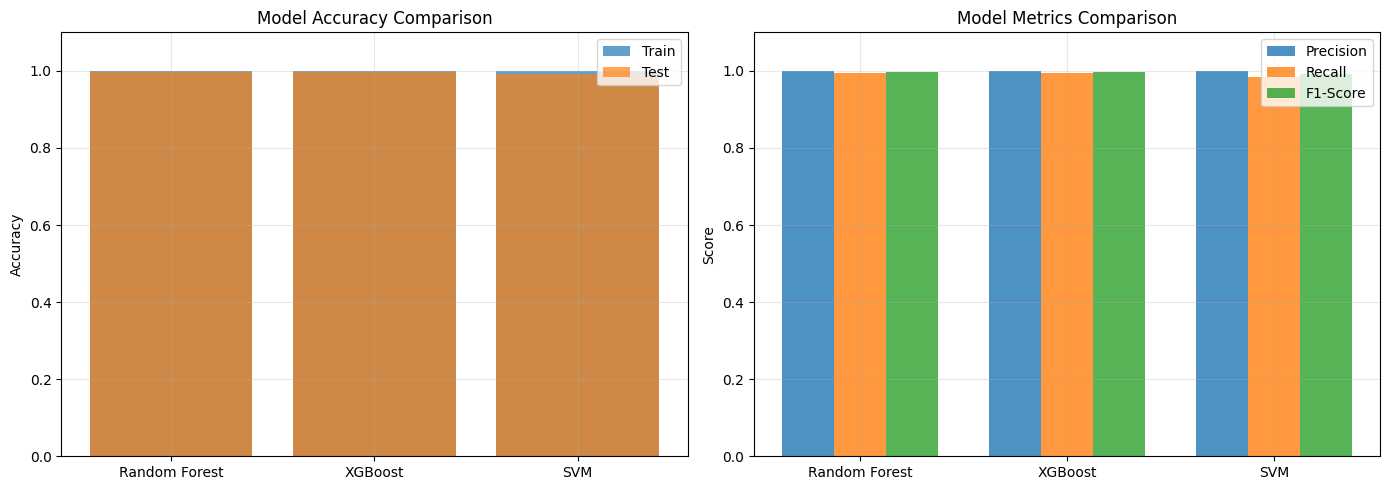

In [ ]:
# Model comparison
models = {
    'Random Forest': rf,
    'XGBoost': xgb,
    'SVM': svm
}

predictions = {
    'Random Forest': y_pred,
    'XGBoost': y_pred_xgb,
    'SVM': y_pred_svm
}

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison = []
for name, model in models.items():
    train_acc = model.score(X_train_scaled, y_train)
    test_acc = model.score(X_test_scaled, y_test)
    y_pred_model = predictions[name]

    from sklearn.metrics import precision_score, recall_score, f1_score

    precision = precision_score(y_test, y_pred_model)
    recall = recall_score(y_test, y_pred_model)
    f1 = f1_score(y_test, y_pred_model)

    comparison.append({
        'Model': name,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

comparison_df = pd.DataFrame(comparison)
print(comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].bar(comparison_df['Model'], comparison_df['Train Acc'], alpha=0.7, label='Train')
axes[0].bar(comparison_df['Model'], comparison_df['Test Acc'], alpha=0.7, label='Test')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].legend()
axes[0].set_ylim([0, 1.1])
axes[0].grid(True, alpha=0.3)

# Metrics comparison
x = np.arange(len(comparison_df))
width = 0.25
axes[1].bar(x - width, comparison_df['Precision'], width, label='Precision', alpha=0.8)
axes[1].bar(x, comparison_df['Recall'], width, label='Recall', alpha=0.8)
axes[1].bar(x + width, comparison_df['F1-Score'], width, label='F1-Score', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df['Model'])
axes[1].set_ylabel('Score')
axes[1].set_title('Model Metrics Comparison')
axes[1].legend()
axes[1].set_ylim([0, 1.1])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# ============================================================================
# STACKING ENSEMBLE
# ============================================================================

print("="*60)
print("TRAINING STACKING ENSEMBLE")
print("="*60)

# Define base models (level 0)
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
    ('xgb', XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                          random_state=42, n_jobs=-1)),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

# Define meta-model (level 1) - combines predictions from base models
meta_model = LogisticRegression(random_state=42)

# Create stacking ensemble
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1
)

# Train the stacking model
print("\nTraining stacking ensemble (this may take a while)...")
stacking_model.fit(X_train_scaled, y_train)

# Evaluate
train_score = stacking_model.score(X_train_scaled, y_train)
test_score = stacking_model.score(X_test_scaled, y_test)

print(f"\n✅ Stacking Ensemble Train Accuracy: {train_score:.4f}")
print(f"✅ Stacking Ensemble Test Accuracy: {test_score:.4f}")

# Predictions
y_pred_stack = stacking_model.predict(X_test_scaled)

print("\nStacking Ensemble Classification Report:")
print(classification_report(y_test, y_pred_stack, target_names=['Healthy', 'Faulty']))

print("\nStacking Ensemble Confusion Matrix:")
cm_stack = confusion_matrix(y_test, y_pred_stack)
print(cm_stack)
print(f"\nTrue Negatives: {cm_stack[0,0]}")
print(f"False Positives: {cm_stack[0,1]}")
print(f"False Negatives: {cm_stack[1,0]}")
print(f"True Positives: {cm_stack[1,1]}")

TRAINING STACKING ENSEMBLE

Training stacking ensemble (this may take a while)...

✅ Stacking Ensemble Train Accuracy: 1.0000
✅ Stacking Ensemble Test Accuracy: 0.9975

Stacking Ensemble Classification Report:
              precision    recall  f1-score   support

     Healthy       0.99      1.00      1.00       199
      Faulty       1.00      0.99      1.00       199

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398


Stacking Ensemble Confusion Matrix:
[[199   0]
 [  1 198]]

True Negatives: 199
False Positives: 0
False Negatives: 1
True Positives: 198


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\n" + "="*60)
print("INDIVIDUAL BASE MODELS PERFORMANCE")
print("="*60)

# Train and evaluate each base model individually
base_results = []

for name, model in base_models:
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)

    train_acc = model.score(X_train_scaled, y_train)
    test_acc = model.score(X_test_scaled, y_test)
    y_pred_base = model.predict(X_test_scaled)

    precision = precision_score(y_test, y_pred_base)
    recall = recall_score(y_test, y_pred_base)
    f1 = f1_score(y_test, y_pred_base)

    base_results.append({
        'Model': name.upper(),
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

    print(f"  Test Accuracy: {test_acc:.4f}")

# Add stacking results
base_results.append({
    'Model': 'STACKING',
    'Train Acc': stacking_model.score(X_train_scaled, y_train),
    'Test Acc': stacking_model.score(X_test_scaled, y_test),
    'Precision': precision_score(y_test, y_pred_stack),
    'Recall': recall_score(y_test, y_pred_stack),
    'F1-Score': f1_score(y_test, y_pred_stack)
})

results_df = pd.DataFrame(base_results)

print("\n" + "="*60)
print("FINAL COMPARISON: BASE MODELS vs STACKING")
print("="*60)
print(results_df.to_string(index=False))


INDIVIDUAL BASE MODELS PERFORMANCE

Training rf...
  Test Accuracy: 0.9975

Training xgb...
  Test Accuracy: 0.9975

Training svm...
  Test Accuracy: 0.9925

Training gb...
  Test Accuracy: 0.9975

Training knn...
  Test Accuracy: 0.9899

FINAL COMPARISON: BASE MODELS vs STACKING
   Model  Train Acc  Test Acc  Precision   Recall  F1-Score
      RF   1.000000  0.997487   1.000000 0.994975  0.997481
     XGB   1.000000  0.997487   1.000000 0.994975  0.997481
     SVM   1.000000  0.992462   1.000000 0.984925  0.992405
      GB   1.000000  0.997487   1.000000 0.994975  0.997481
     KNN   0.994347  0.989950   0.994924 0.984925  0.989899
STACKING   1.000000  0.997487   1.000000 0.994975  0.997481


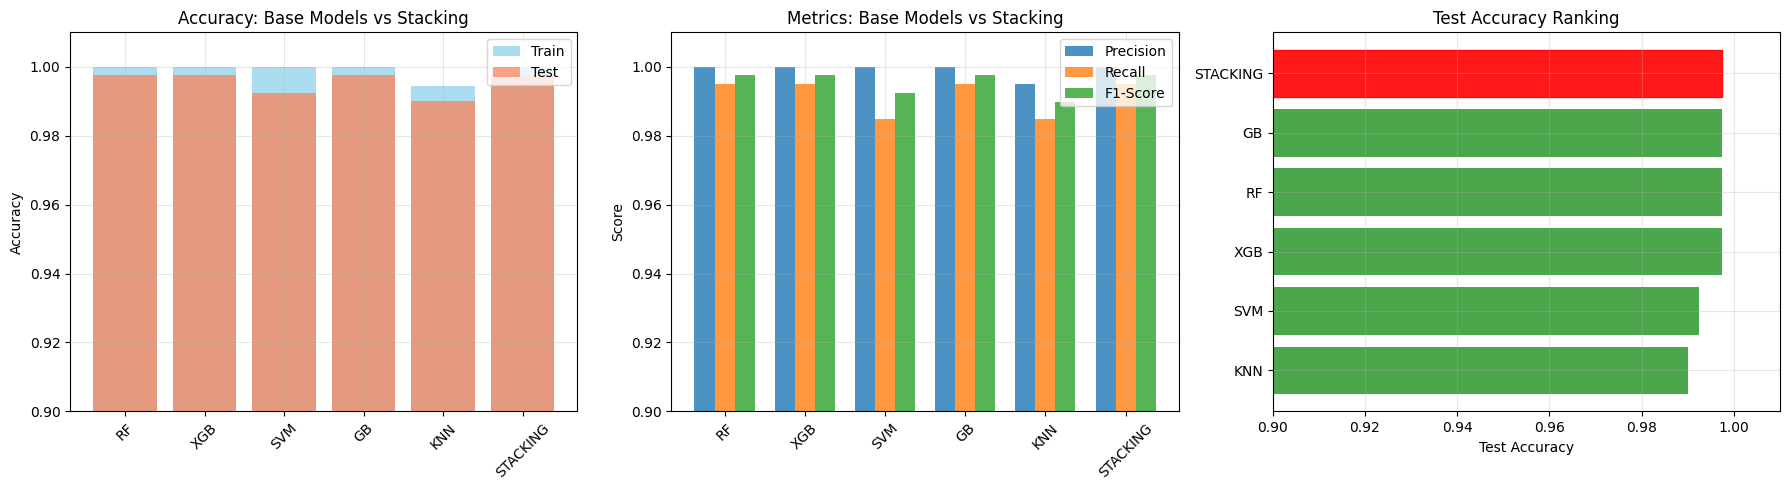


🏆 Best Model: RF with Test Accuracy: 0.9975


In [ ]:
# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Accuracy comparison
axes[0].bar(results_df['Model'], results_df['Train Acc'], alpha=0.7, label='Train', color='skyblue')
axes[0].bar(results_df['Model'], results_df['Test Acc'], alpha=0.7, label='Test', color='coral')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy: Base Models vs Stacking')
axes[0].legend()
axes[0].set_ylim([0.9, 1.01])  # Zoom in to see differences
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# 2. Precision, Recall, F1 comparison
x = np.arange(len(results_df))
width = 0.25
axes[1].bar(x - width, results_df['Precision'], width, label='Precision', alpha=0.8)
axes[1].bar(x, results_df['Recall'], width, label='Recall', alpha=0.8)
axes[1].bar(x + width, results_df['F1-Score'], width, label='F1-Score', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45)
axes[1].set_ylabel('Score')
axes[1].set_title('Metrics: Base Models vs Stacking')
axes[1].legend()
axes[1].set_ylim([0.9, 1.01])
axes[1].grid(True, alpha=0.3)

# 3. Test accuracy ranking
sorted_results = results_df.sort_values('Test Acc', ascending=True)
axes[2].barh(sorted_results['Model'], sorted_results['Test Acc'], color='green', alpha=0.7)
axes[2].set_xlabel('Test Accuracy')
axes[2].set_title('Test Accuracy Ranking')
axes[2].set_xlim([0.9, 1.01])
axes[2].grid(True, alpha=0.3)

# Highlight stacking
for i, model in enumerate(sorted_results['Model']):
    if model == 'STACKING':
        axes[2].get_children()[i].set_color('red')
        axes[2].get_children()[i].set_alpha(0.9)

plt.tight_layout()
plt.show()

# Show which model performed best
best_model = results_df.loc[results_df['Test Acc'].idxmax()]
print(f"\n🏆 Best Model: {best_model['Model']} with Test Accuracy: {best_model['Test Acc']:.4f}")


TESTING DIFFERENT META-MODELS

Testing with meta-model: Logistic Regression...
  Test Accuracy: 0.9975

Testing with meta-model: Random Forest...
  Test Accuracy: 0.9975

Testing with meta-model: Decision Tree...
  Test Accuracy: 0.9975

Testing with meta-model: Gradient Boosting...
  Test Accuracy: 0.9975

META-MODEL COMPARISON
         Meta-Model  Test Accuracy
Logistic Regression       0.997487
      Random Forest       0.997487
      Decision Tree       0.997487
  Gradient Boosting       0.997487


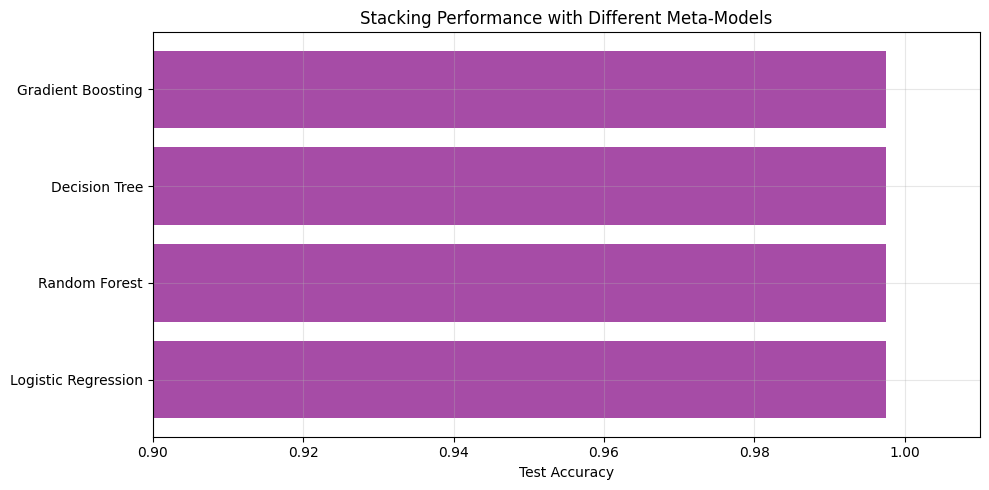

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

print("\n" + "="*60)
print("TESTING DIFFERENT META-MODELS")
print("="*60)

meta_models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, random_state=42)
}

meta_results = []

for meta_name, meta_clf in meta_models.items():
    print(f"\nTesting with meta-model: {meta_name}...")

    stack = StackingClassifier(
        estimators=base_models,
        final_estimator=meta_clf,
        cv=5,
        n_jobs=-1
    )

    stack.fit(X_train_scaled, y_train)
    test_acc = stack.score(X_test_scaled, y_test)

    meta_results.append({
        'Meta-Model': meta_name,
        'Test Accuracy': test_acc
    })

    print(f"  Test Accuracy: {test_acc:.4f}")

meta_df = pd.DataFrame(meta_results).sort_values('Test Accuracy', ascending=False)
print("\n" + "="*60)
print("META-MODEL COMPARISON")
print("="*60)
print(meta_df.to_string(index=False))

# Plot
plt.figure(figsize=(10, 5))
plt.barh(meta_df['Meta-Model'], meta_df['Test Accuracy'], color='purple', alpha=0.7)
plt.xlabel('Test Accuracy')
plt.title('Stacking Performance with Different Meta-Models')
plt.xlim([0.9, 1.01])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**MULTI CLASS HEADER**

In [ ]:
# ============================================================================
# MULTI-CLASS CLASSIFICATION (10 CONDITIONS)
# ============================================================================

# Create numeric labels for all 10 conditions
label_mapping = {
    'normal_no_load': 0,
    'phase_removed_no_load': 1,
    'load_0.4Nm': 2,
    'load_0.8Nm': 3,
    'phase_removed_startup': 4,
}

# Create labels - combine status + condition for unique classes
features_df['class_label'] = features_df['status'] + '_' + features_df['condition']

# Map to numbers
unique_classes = features_df['class_label'].unique()
class_to_num = {cls: idx for idx, cls in enumerate(sorted(unique_classes))}
features_df['numeric_label'] = features_df['class_label'].map(class_to_num)

print("Class mapping:")
for cls, num in sorted(class_to_num.items(), key=lambda x: x[1]):
    print(f"  {num}: {cls}")

# Prepare data
X = features_df.drop(['file_id', 'status', 'condition', 'label', 'class_label', 'numeric_label'], axis=1)
y = features_df['numeric_label'].values

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=42, stratify=y
)

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of classes: {len(unique_classes)}")

Class mapping:
  0: faulty_load_0.4Nm
  1: faulty_load_0.8Nm
  2: faulty_normal_no_load
  3: faulty_phase_removed_no_load
  4: faulty_phase_removed_startup
  5: healthy_load_0.4Nm
  6: healthy_load_0.8Nm
  7: healthy_normal_no_load
  8: healthy_phase_removed_no_load
  9: healthy_phase_removed_startup

Training samples: 1393
Test samples: 597
Number of features: 148
Number of classes: 10


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Callbacks
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
    monitor='val_loss',
    save_best_only=True
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=0.0001
)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Create model
def create_model(input_dim, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

# Build model
model = create_model(input_dim=X_train_scaled.shape[1], num_classes=len(unique_classes))
model.summary()

# Train
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         9,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,682 (362.04 KB)

 Trainable params: 92,682 (362.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1148 - loss: 2.3329

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1281 - loss: 2.2969 - val_accuracy: 0.4516 - val_loss: 1.7085 - learning_rate: 0.0010
Epoch 2/50
31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3355 - loss: 1.7459

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3447 - loss: 1.7282 - val_accuracy: 0.7061 - val_loss: 1.0652 - learning_rate: 0.0010
Epoch 3/50
30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5287 - loss: 1.3102

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5333 - loss: 1.2948 - val_accuracy: 0.7814 - val_loss: 0.6749 - learning_rate: 0.0010
Epoch 4/50
25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6142 - loss: 1.0088

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6244 - loss: 0.9789 - val_accuracy: 0.9247 - val_loss: 0.4338 - learning_rate: 0.0010
Epoch 5/50
28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6968 - loss: 0.7298

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7038 - loss: 0.7368 - val_accuracy: 0.9498 - val_loss: 0.2893 - learning_rate: 0.0010
Epoch 6/50
29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8206 - loss: 0.5221

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8220 - loss: 0.5179 - val_accuracy: 0.9821 - val_loss: 0.1989 - learning_rate: 0.0010
Epoch 7/50
30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8783 - loss: 0.3942

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8788 - loss: 0.3860 - val_accuracy: 0.9928 - val_loss: 0.0907 - learning_rate: 0.0010
Epoch 8/50
28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9005 - loss: 0.2742

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8992 - loss: 0.2821 - val_accuracy: 0.9928 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 9/50
29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9165 - loss: 0.2751

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9178 - loss: 0.2723 - val_accuracy: 0.9964 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 10/50
27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9325 - loss: 0.2343

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9319 - loss: 0.2328 - val_accuracy: 0.9928 - val_loss: 0.0212 - learning_rate: 0.0010
Epoch 11/50
30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9572 - loss: 0.1342

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9570 - loss: 0.1364 - val_accuracy: 0.9928 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 12/50
27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9358 - loss: 0.2068

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9385 - loss: 0.1983 - val_accuracy: 1.0000 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 13/50
28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9666 - loss: 0.1302

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9646 - loss: 0.1318 - val_accuracy: 1.0000 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9622 - loss: 0.1358 - val_accuracy: 0.9964 - val_loss: 0.0387 - learning_rate: 0.0010
Epoch 15/50
25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9483 - loss: 0.1376

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9522 - loss: 0.1298 - val_accuracy: 1.0000 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 16/50
27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9652 - loss: 0.1019

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9659 - loss: 0.1018 - val_accuracy: 1.0000 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 17/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9752 - loss: 0.1001 - val_accuracy: 0.9964 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 12.



✅ Neural Network Train Accuracy: 0.9986
✅ Neural Network Test Accuracy: 0.9933
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Neural Network Classification Report:
                               precision    recall  f1-score   support

            faulty_load_0.4Nm       0.98      1.00      0.99        60
            faulty_load_0.8Nm       1.00      1.00      1.00        59
        faulty_normal_no_load       1.00      0.97      0.98        60
 faulty_phase_removed_no_load       1.00      0.98      0.99        60
 faulty_phase_removed_startup       1.00      1.00      1.00        60
           healthy_load_0.4Nm       0.98      1.00      0.99        59
           healthy_load_0.8Nm       1.00      1.00      1.00        60
       healthy_normal_no_load       0.97      0.98      0.98        60
healthy_phase_removed_no_load       1.00      1.00      1.00        59
healthy_phase_removed_startup       1.00      1.00      1.00        60

                     accuracy                           0.9

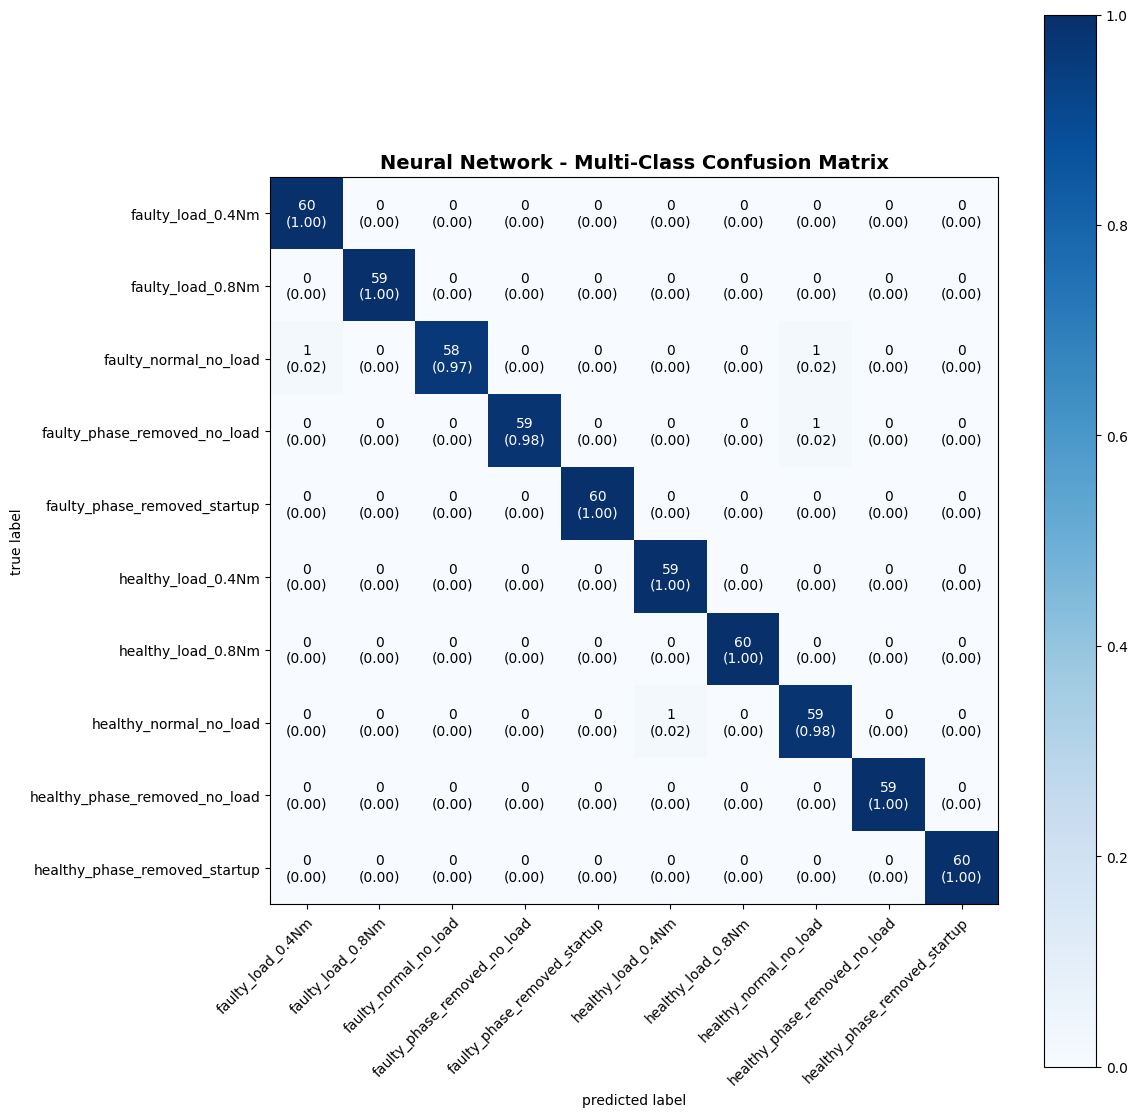

In [ ]:
# Evaluate
train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\n✅ Neural Network Train Accuracy: {train_acc:.4f}")
print(f"✅ Neural Network Test Accuracy: {test_acc:.4f}")

# Predictions
y_pred_nn = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
class_names = [cls for cls, _ in sorted(class_to_num.items(), key=lambda x: x[1])]

print("\nNeural Network Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Confusion matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test, y_pred_classes)
fig, ax = plot_confusion_matrix(
    conf_mat=cm,
    class_names=class_names,
    figsize=(12, 12),
    show_absolute=True,
    show_normed=True,
    colorbar=True,
)
plt.title('Neural Network - Multi-Class Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

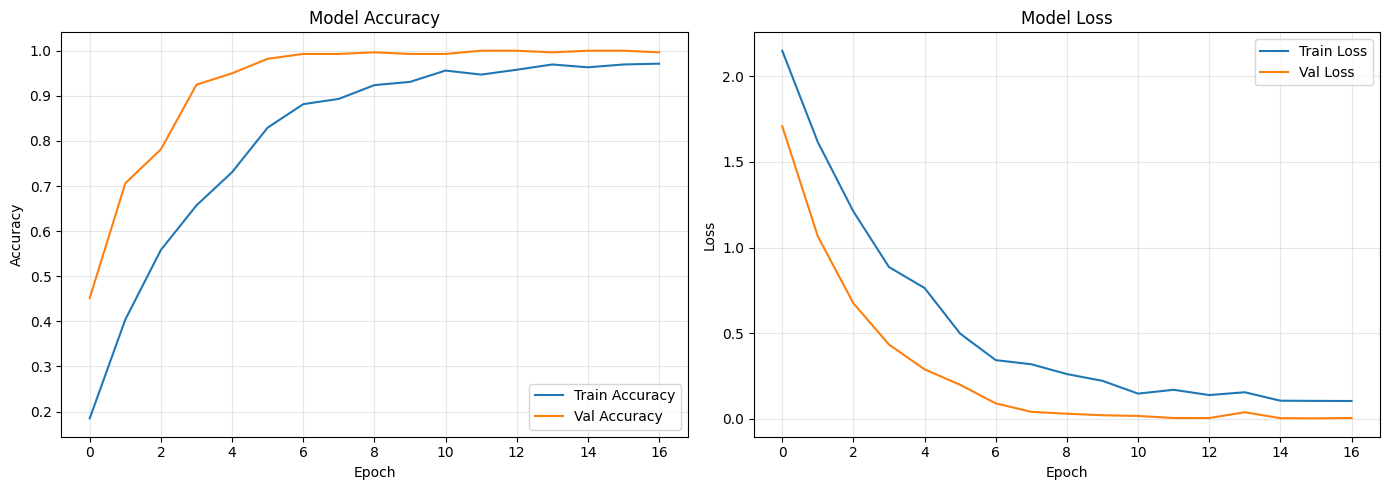

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


COMPARING MODELS ON MULTI-CLASS CLASSIFICATION

Training Random Forest...
  Test Accuracy: 0.9966

Training XGBoost...
  Test Accuracy: 0.9950

Training SVM...
  Test Accuracy: 0.9933
  Test Accuracy: 0.9933

MULTI-CLASS RESULTS
         Model  Train Accuracy  Test Accuracy
 Random Forest        1.000000       0.996650
       XGBoost        1.000000       0.994975
           SVM        0.999282       0.993300
Neural Network        0.999282       0.993300


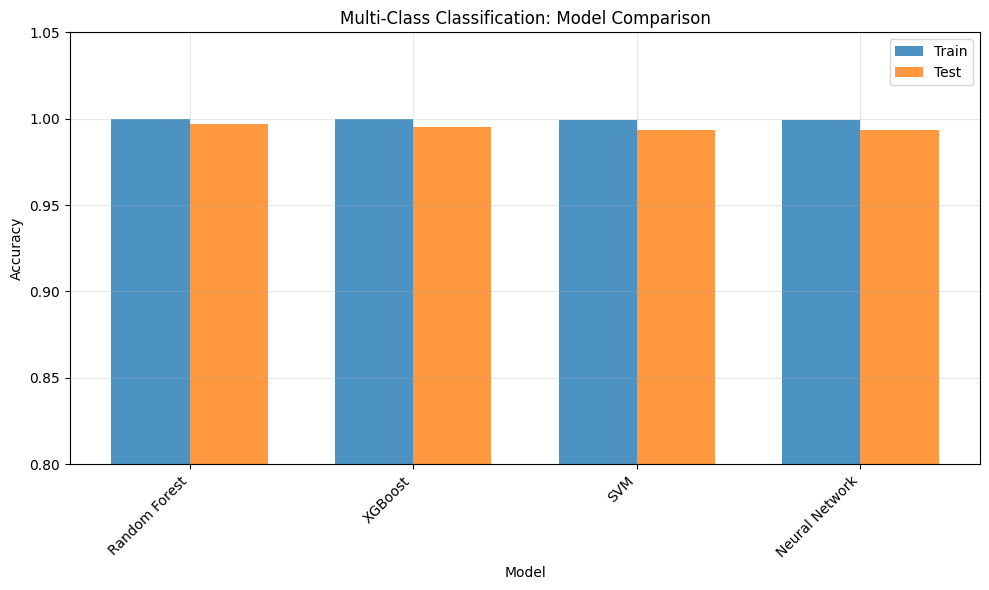

In [ ]:
# Train ML models on multi-class
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

print("\n" + "="*60)
print("COMPARING MODELS ON MULTI-CLASS CLASSIFICATION")
print("="*60)

models_multi = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Neural Network': None  # Already trained
}

results_multi = []

for name, model in models_multi.items():
    if name != 'Neural Network':
        print(f"\nTraining {name}...")
        model.fit(X_train_scaled, y_train)
        train_acc = model.score(X_train_scaled, y_train)
        test_acc = model.score(X_test_scaled, y_test)
    else:
        train_acc = train_acc  # From NN evaluation above
        test_acc = test_acc

    results_multi.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc
    })

    print(f"  Test Accuracy: {test_acc:.4f}")

results_df_multi = pd.DataFrame(results_multi)
print("\n" + "="*60)
print("MULTI-CLASS RESULTS")
print("="*60)
print(results_df_multi.to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
x = np.arange(len(results_df_multi))
width = 0.35
plt.bar(x - width/2, results_df_multi['Train Accuracy'], width, label='Train', alpha=0.8)
plt.bar(x + width/2, results_df_multi['Test Accuracy'], width, label='Test', alpha=0.8)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Multi-Class Classification: Model Comparison')
plt.xticks(x, results_df_multi['Model'], rotation=45, ha='right')
plt.legend()
plt.ylim([0.8, 1.05])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()